In [ ]:
import time
import csv
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import tqdm
import math
from scipy.stats import kurtosis
from scipy.stats import skew
from tqdm import tqdm
from statistics import median
from tqdm import tqdm

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import preprocessing

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import lightgbm as lgb

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from pathlib import Path
import os


import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
# from lime import lime_tabular

In [ ]:
start_time = time.time()

In [ ]:
def psg_read_precleaned(folder):
        par_folder=os.getcwd()
        data=pd.DataFrame()
        data_path = par_folder+'/data/'+folder+'/'
        files = os.listdir(data_path) # dir is your directory path
        number_files = len(files)
        for i in range(1,number_files+1):
                file_path=(par_folder+'/data/'+folder+'/hrv'+str(i)+".csv")
                # if(folder=='ID3'):
                #         print(file_path)
                data=data.append(pd.read_csv(file_path))
        return data
                

In [ ]:
data=psg_read_precleaned('ID1')
data=data.append(psg_read_precleaned('ID2'))
data=data.append(psg_read_precleaned('ID3'))
data.reset_index(inplace=True,drop=True)
data

### Run here from 2nd time

In [ ]:
data.isnull().sum(axis = 0)


In [ ]:
data.columns

In [ ]:
data['STAGE'].value_counts()
data=data.loc[data['STAGE']!='MT']
data.STAGE.value_counts()

In [ ]:
corr = data.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()


In [70]:
def training_classifiers(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                      test_size=0.15, 
                                                      random_state=42) 
                                                    #   ,stratify= y)
    '''                                                      
    print("Training ****** RANDOM FOREST ******")
    model = RandomForestClassifier(n_estimators=800, n_jobs=-1,verbose=1)
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_pred))
    plot_confusion_matrix(model, X_test, y_test) 
    plt.show()
    
    print("Training ****** Linear SVC ******")
    model = LinearSVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_test))
    print(metrics.classification_report(y_test, y_pred))
    plot_confusion_matrix(model, X_test, y_test) 
    plt.show()
    
    
    print("Training ****** Logistic Regression ******")
    LR_model = LogisticRegression(verbose=True)
    clf=LR_model.fit(X_train, y_train)
    y_pred = LR_model.predict(X_test)
    acc_score = LR_model.score(X_test, y_test)
    print(acc_score)
    print(metrics.classification_report(y_test, y_pred))
    plot_confusion_matrix(clf, X_test, y_test) 
    plt.show()
    
    print("Training ****** XGBoost ******")
    model = XGBClassifier(n_jobs=-1,use_label_encoder=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print(metrics.classification_report(y_test, y_pred))
    plot_confusion_matrix(model, X_test, y_test) 
    plt.show()
    '''
    
    models = [
        RandomForestClassifier(n_estimators=5000,random_state=42),
        LinearSVC(),
        LogisticRegression(random_state=42),
        XGBClassifier(n_jobs=-1,use_label_encoder=True),
        GaussianNB(),
        svm.SVC(kernel='rbf')
    ]
    CV = 3
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    
    plt.show()

In [53]:

FEATURES=['MEDIAN', 'MEAN_NN', 'MxDMn', 'MAXN', 'MINN', 'VARIA',
       'ABSOLUTE_POWER_LF', 'ABSOLUTE_POWER_HF', 'TOTAl_POWER', 'KURT', 'SKEW',
       'KURT_REL_RR', 'SKEW_REL_RR']
X=data[FEATURES]
y=data['STAGE']

# sc = StandardScaler()
# X = sc.fit_transform(X)

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)


dtf_scaled= pd.DataFrame(X,index=data.index)
dtf_scaled["STAGE"] = data["STAGE"]
dtf_scaled.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,STAGE
0,0.555263,0.506720,0.544267,0.588832,0.223164,0.144100,0.060046,0.058173,0.113265,0.214502,0.621549,0.293726,0.326111,S2
1,0.552632,0.508253,0.284470,0.262267,0.183616,0.041987,0.007673,0.007873,0.011784,0.613491,0.175402,0.560419,0.189778,S2
2,0.571053,0.545662,0.207547,0.306261,0.406780,0.028937,0.040931,0.014759,0.035494,0.212314,0.417316,0.172230,0.411332,S2
3,0.394737,0.300730,0.528302,0.446700,0.016949,0.340670,0.079502,0.132134,0.221553,0.030823,0.535065,0.103871,0.573931,S2
4,0.305263,0.186564,0.419448,0.313029,0.005650,0.273019,0.016651,0.175341,0.189080,0.029602,0.566836,0.057349,0.482851,S2


## Feature Importance

Text(0.5, 1, 'pearson correlation')

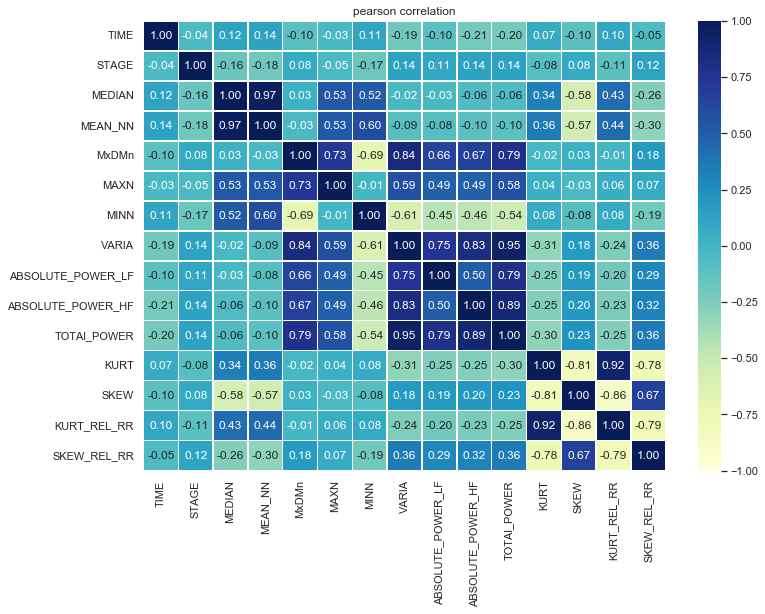

In [55]:
corr_matrix = data.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

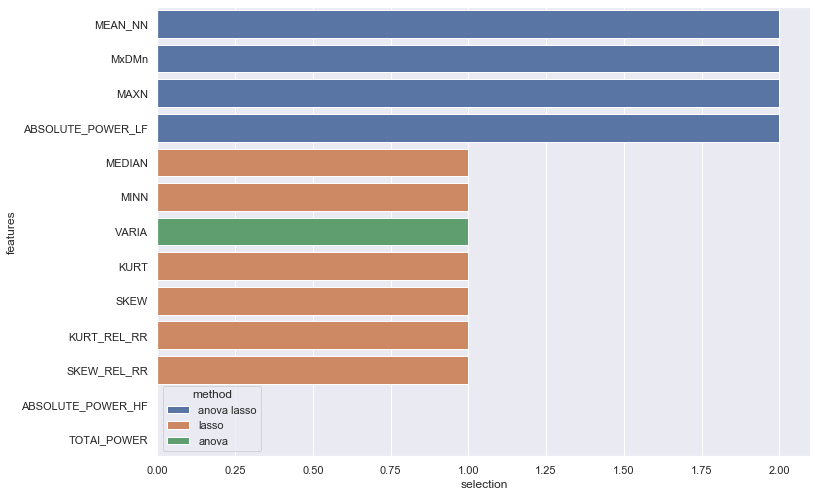

In [65]:
X = data.drop(["TIME","STAGE"], axis=1).values
y = data["STAGE"].values
feature_names = data.drop(["TIME","STAGE"], axis=1).columns
# Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=5).fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=10).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]
 
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)


In [73]:
#using both HR and Acc features

FEATURES=['MEDIAN', 'MEAN_NN', 'MxDMn', 'MAXN', 'MINN', 'VARIA',
       'ABSOLUTE_POWER_LF', 'ABSOLUTE_POWER_HF', 'TOTAl_POWER', 'KURT', 'SKEW',
       'KURT_REL_RR', 'SKEW_REL_RR']
training_classifiers(data[FEATURES],data['STAGE'])

/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

[15:50:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

[15:47:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


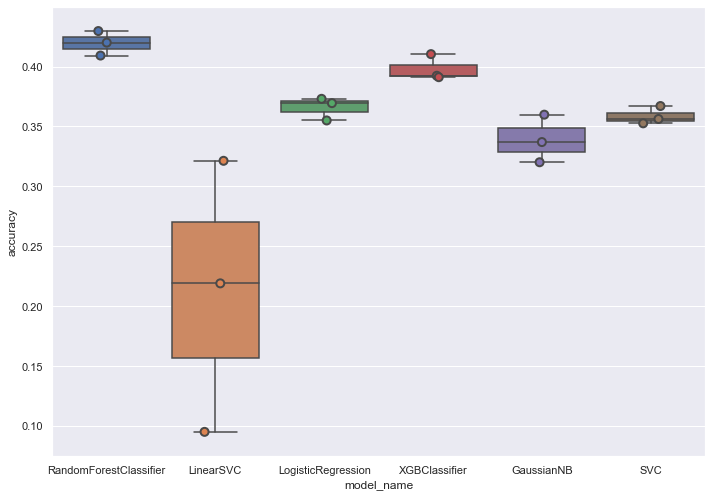

In [71]:
FEATURES=['MEAN_NN', 'MxDMn', 'MAXN', 
       'ABSOLUTE_POWER_LF', 'KURT', 'SKEW']
training_classifiers(data[FEATURES],data['STAGE'])

/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

[15:48:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mohitbagaria/opt/anaconda3/envs/sleep_staging/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


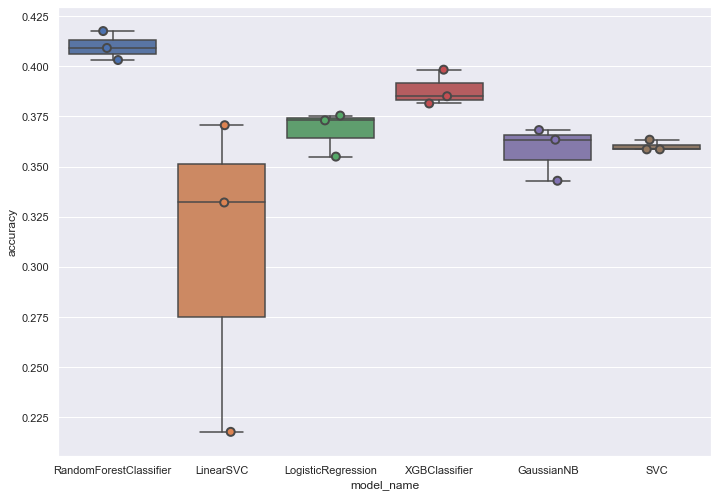

In [72]:
FEATURES=['MEAN_NN', 'MxDMn', 'MAXN', 
       'ABSOLUTE_POWER_LF']
training_classifiers(data[FEATURES],data['STAGE'])

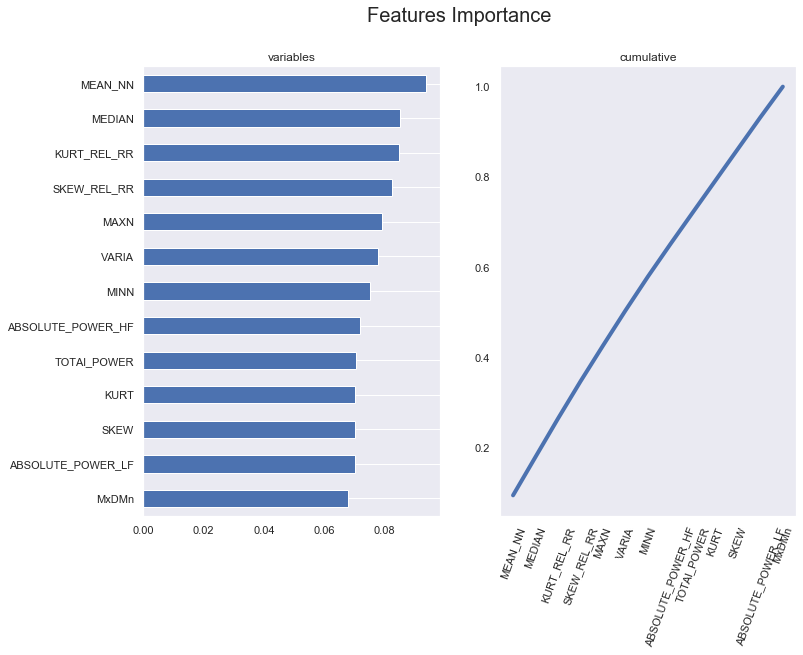

In [68]:
dtf_train=data.copy()
X = dtf_train.drop(['STAGE','TIME'], axis=1).values
y = dtf_train['STAGE'].values
feature_names = dtf_train.drop(['STAGE','TIME'], axis=1).columns.tolist()
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()